# Aligning biological sequences using DCAlign

In the following, we will show:
- how to get a seed model, i.e. the DCA parameters as well as the empirical priors, from the seed (Pfam or Rfam);
- the main steps needed to align a sequence to a seed model. 
As an example, we deal with the Pfam family PF00684, PF00035 and Rfam family RF00167


#### 1. Let us load the DCAlign.jl package:


In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using DCAlign
using DelimitedFiles

  Activating project at `~/CODE/DCAlign/notebook`


#### 2. Select the family

The variable `q` denotes the number of symbols (21 for protein and 5 for RNA sequences). 

The type of sequence must be specified in the `ctype` variable. 

`fileseed` is a file containing the seed sequences in Stockholm format. When dealing with Pfam or Rfam seeds, these files can be download from the corresponding websites.


In [2]:
fam = "PF00684"
q = 21;
ctype = :amino
#Pfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = ""

""

In [2]:
fam = "RF00167"
q = 5;
ctype = :nbase
#Rfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = ""

""

In [88]:
fam = "PF00035"
q = 21;
ctype = :amino
#Pfam seed in Stockholm format
fileseed = "../seeds/" * fam * "_seed.txt"
extra = ""

""

#### 3. Get the seed in FASTA and FASTA + insertions format

To get a correct assignment of the insertions and gaps within the seed sequences, we build a Hidden Markov Model (HMM), or a Covariance Model (CM), for the seed. This procedure, together with a seed model (not used) returns an alignment of the seed, stored in the `seedfasta` file. This also determines the length of the model `L`.

For proteins: Pay attention that to get the aligned sequences of the correct length, i.e. the length of the aligned sequences in the Pfam repository, one has to install HMMER 3.1b2. This version is that used in the seed HMM present in the website.

To learn the empirical prior over the pointer-difference variables we need to store the aligned sequences, containing insertions as lower-case symbols, in a separate file `seedins`.

In [3]:
out_label = "../seeds/" * fam * "_seed"
if ctype == :amino
    L = align_seed_pfam(fileseed, "../seeds/" * fam * "_seed", extra=extra)
else
    L = align_seed_rfam(fileseed, "../seeds/" * fam * "_seed", extra=extra)
end
seedfasta = out_label * ".fasta"
seedins = out_label * ".ins"

┌ Info: Working in /var/folders/3r/g2x6wc792nx9j1zvy02vj_tw0000gn/T/jl_MymLqm
└ @ DCAlign /Users/pagnani/.julia/packages/DCAlign/9aqBm/src/seed_utils.jl:135
┌ Info: ### Computing the CM and get aligned seed (with and without insertions)
└ @ DCAlign /Users/pagnani/.julia/packages/DCAlign/9aqBm/src/seed_utils.jl:136
┌ Info: L = 102
└ @ DCAlign /Users/pagnani/.julia/packages/DCAlign/9aqBm/src/seed_utils.jl:146
┌ Info: Done!
└ @ DCAlign /Users/pagnani/.julia/packages/DCAlign/9aqBm/src/seed_utils.jl:147


"../seeds/RF00167_seed.ins"

#### 4. Learn the prior for $\Lambda \left( \Delta n \right)$

We store all the empirical frequencies for positions $i = 1, \cdots, L$, $j > i$, and $\Delta n = n_{j} - n_{i}$ in $\Lambda[i,j,\Delta n]$.

In [4]:
Λ, Mseed, _ = DCAlign.deltan_prior(seedins, L); # i j Δn

Maximum Δn 105


#### 5. Learn the DCA seed model using PlmDCA

Among all possible methods to learn a Direct Coupling Analysis model for the aligned seed, we choose [PlmDCA](https://doi.org/10.1103/PhysRevE.87.012707) for its reduced running time.

Since the Julia implementation of PlmDCA is not registered in Julia repository, one has to install it from the PackageManager by typing

```(v1.?) pkg> add https://github.com/pagnani/PlmDCA```

 For seed having a few sequences (< 100), it is preferable to use a very small regularization parameter, i.e. $\lambda_{J} = \lambda_{h} = 10^{-6}$

In [5]:
using PlmDCA

if ctype == :amino
    if abs(L - Mseed) > 100
        PlmOut = plmdca(seedfasta)
    else
        PlmOut = plmdca(seedfasta, lambdaJ=0.000001, lambdaH=0.000001)
    end
else
    Z, W = DCAlign.get_Z_W(seedfasta, ctype)
    if abs(L - Mseed) > 100
        PlmOut = plmdca(Z, W)
    else
        PlmOut = plmdca(Z, W, lambdaH=0.000001, lambdaJ=0.000001)
    end
end
J = PlmOut.Jtensor
h = PlmOut.htensor;

site = 91	 pl = 0.0004	 time = 14.7191	exit status = FTOL_REACHED
site = 14	 pl = 0.0005	 time = 14.5250	exit status = FTOL_REACHED
site = 66	 pl = 0.0000	 time = 14.5022	exit status = FTOL_REACHED
site = 27	 pl = 0.0000	 time = 14.4958	exit status = FTOL_REACHED
site = 92	 pl = 0.0005	 time = 0.0184	exit status = FTOL_REACHED
site = 15	 pl = 0.0005	 time = 0.0198	exit status = FTOL_REACHED
site = 79	 pl = 0.0001	 time = 14.5042	exit status = FTOL_REACHED
site = 53	 pl = 0.0000	 time = 14.7753	exit status = FTOL_REACHED
site = 28	 pl = 0.0002	 time = 0.0158	exit status = FTOL_REACHED
site = 54	 pl = 0.0000	 time = 0.0053	exit status = FTOL_REACHED
site = 80	 pl = 0.0000	 time = 0.0121	exit status = FTOL_REACHED
site = 67	 pl = 0.0003	 time = 0.0230	exit status = FTOL_REACHED
site = 55	 pl = 0.0000	 time = 0.0059	exit status = FTOL_REACHED
site = 93	 pl = 0.0005	 time = 0.0214	exit status = FTOL_REACHED
site = 40	 pl = 0.0004	 time = 14.7920	exit status = FTOL_REACHED
site = 1	 pl = 0.0

#### 6. Load sequences

The function `DCAlign.enveloptoalign` takes as input 
1. a full set of non-aligned sequences alone 
2. a full set of non-aligned sequences together with a known alignment in two formats (a standard insertions-free MSA and a MSA where insertions are added as lower case symbols). 

All files should be written according to the FASTA layout

Ex.

```
PF1_full.fasta 

    >Seq01
    SLSTAQLLQPSGGLQASVISNIVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGRLQEGDEILELNGESMAGLTHQDALQKFK
    QAKKGLLTLTVRTRLTAPHALGGPLSPPLSRS

PF1_align.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGLQEGDEILELNGESMAGLTHQDALQKFKQAKKLLTLTVR

PF1_ins.fasta

    >Seq01/22-104
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGrLQEGDEILELNGESMAGLTHQDALQKFKQAKKgLLTLTVR
```

Only for RNA, the names of full-length sequences must contain the position of the hit (in agreement with the standard Rfam format).

You must also specify in `ctype` the type of variables (amino-acids or nucleic bases) and, when the aligned sequences are added as input, the cut-off size `delta` of the full length sequences (the final length will be  `delta_ + _L_ + _delta`)

Usage
1. >seq = DCAlign.enveloptoalign("PF1_full.fasta", ctype = :amino)
2. >seq = DCAlign.enveloptoalign("PF1_full.fasta", "PF1_align.fasta", "PF1_ins.fasta", delta = 20, ctype = :amino)

In the fist case `seq` is a dictionary whereas in the last case it contains for all sequences in $i = 1,\cdots,M$ using the following format:
    
    seq[i][1] : name
    seq[i][2] : full length sequence
    seq[i][3] : aligned sequence
    seq[i][4] : aligned sequence with insertions


In [6]:
delta = 20
al = DCAlign.enveloptoalign("../test/" * fam * "/" * fam * "_full_length_sequences.fasta",
    "../test/" * fam * "/" * fam * "_full.fasta",
    "../test/" * fam * "/" * fam * "_full.ins",
    delta=delta, ctype=ctype
)
M = length(al)
println("Tot. number of sequences ", M)
idx0 = rand(1:M)
println("Consider this sequence: ")
(aux, garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMer (without and with insertions): ")
println(seqsol)
println(seqins)


Tot. number of sequences 2660
Consider this sequence: 
BALG01000023.1/14892-14793
Full length: 
TGCAAGCATTATGATTCTGTTCGTATATTCCCGAAGATAAGGTCCGGGGGTCTCTACCAGGAGCCGTAAATTCCTGACTACGAGCGGTGTGCTTCCGCAT
Aligned by HMMer (without and with insertions): 
UGCAAGCAUUAUGAUUCUGUUCGUAUAUUCCCGAAGAUAAGGUCCGGGGGUCUCUACCAGGAG-CCGUAAA-UUCCUGACUACGAGCGGUGUGCUUCCGCAU
UGCAAGCAUUAUGAUUCUGUUCGUAUAUUCCCGAAGAUAAGGUCCGGGGGUCUCUACCAGGAG-CCGUAAA-UUCCUGACUACGAGCGGUGUGCUUCCGCAU


#### 7. Run DCAlign

Run the approximate message-passing algorithm coupled with the annealing scheme. In particular, each $\Delta t$ iterations, $\beta$ is updated as $\beta += \Delta \beta$.

Convergence is reached when:
- The approximate marginals are sufficiently concentrated, i.e. $\min_{i} \max_{x,n} P_{i} \left(x,n\right) < thP$. A reasonable value for $thP$ is 0.30;
- The assignment of the variables gives a properly ordered sequence.

The aligned sequence is compared to a test one by using their Hamming distance and their energies. The latters only consider the Potts energy of the DCA model associated with the seed sequences.

In [7]:
damp = 0.0
seed = 0
pcount = 1.0 / Mseed

@time _, _, res, _ = DCAlign.palign(seq, J, h, Λ, ctype,
    nprint=100, maxiter=1000, seed=seed, thP=0.30, Δβ=0.05,
    damp=damp, verbose=true, pcount=pcount);


marg = deepcopy(res.pbf.P)

P = copy(res.pbf.P)
out = DCAlign.decodeposterior(P, res.seq.strseq, thP=res.alg.thP);
seqpa = out.seq # aligned seq 
seqpo = out.seqins # aligned seq with insertions
sat = DCAlign.check_assignment(P, true, N)

if sat == false
    (seqpa, P) = DCAlign.decimate_post(res, false)
    out = DCAlign.decodeposterior(P, res.seq.strseq, thP=res.alg.thP)
    seqpo = out.seqins
    println("Nucleation sol (a): ", out.seq)
    println("Nucleation sol (ins): ", out.seqins)
    println("(Potts) energy nucl sol: ", DCAlign.compute_potts_en(J, h, out.seq, L, ctype))
end

Ngap, Nins, Nb = DCAlign.count_gaps_ins(out.seqins)
hdist, Gapp, Gapm, Sm = DCAlign.hammingdist(out.seq, seqsol)
println("test           ", seqsol)
println("dcalign.seq    ", out.seq)
println("score          ", out.score)
println("Hamming distance (dcalign, test) = ", hdist)

en = DCAlign.compute_potts_en(J, h, out.seq, L, ctype)
ensol = DCAlign.compute_potts_en(J, h, seqsol, L, ctype)

seq_c = seqpa
println("(Potts) energy of the sequence aligned by DCAlign ", en)
println("(Potts) energy of the compared sequence ", ensol)

Run DCAlign for RNA or protein alignment
Looking for a fragment...more time needed
L = 102: length of the Potts model
N = 100: length of the sequence A to be aligned
A: UGCAAGCAUUAUGAUUCUGUUCGUAUAUUCCCGAAGAUAAGGUCCGGGGGUCUCUACCAGGAGCCGUAAAUUCCUGACUACGAGCGGUGUGCUUCCGCAU


it = 8 -- en = -565.73 sat = 1 min(max P) = 5.53e-01 β = 1.00 (ΔP,ΔB,ΔF) = 5.46e-01 7.68e-01 7.46e-01 
  8.542591 seconds (12.58 M allocations: 637.964 MiB, 3.03% gc time, 63.49% compilation time)
Let us check the assignment...
The subsequence satisfies the constraints
test           UGCAAGCAUUAUGAUUCUGUUCGUAUAUUCCCGAAGAUAAGGUCCGGGGGUCUCUACCAGGAG-CCGUAAA-UUCCUGACUACGAGCGGUGUGCUUCCGCAU
dcalign.seq    UGCAAGCAUUAUGAUUCUGUUCGUAUAUUCCCGAAGAUAAGGUCCGGGGGUCUCUACCAGGAG-CCGUAAA-UUCCUGACUACGAGCGGUGUGCUUCCGCAU
score          999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999988955
Hamming distance (dcalign, test) = 0
(Potts) energy of the sequence aligned by DCAlign -565.7300993237247
(Potts) energy of the compared sequence -565.7300993237247


#### 8. Marginal probabilities at convergence

Let us plot the (approximate) marginal probability at convergence.

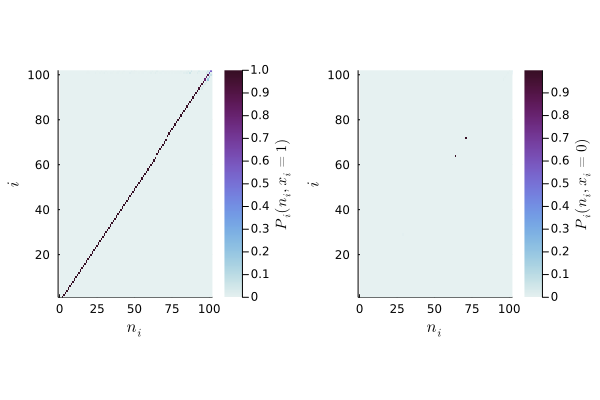

In [8]:

using Plots
using ColorSchemes
using LaTeXStrings
N = length(seq.intseq)

M = zeros(L, N + 2)

for i = 1:L
    m = marg[i]
    for n = 0:N+1
        M[i, n+1] = m[1, n]
    end
end


col = cgrad(:dense)
m1 = minimum(M)
m2 = maximum(M)

p1 = heatmap(M, c=col, aspect_ratio=1.5, xlims=(-1, N + 2), ylims=(1, L), colorbar_title=L"P_{i}(n_{i}, x_{i} = 1)")
M = zeros(L, N + 2)
for i = 1:L
    m = marg[i]
    for n = 0:N+1
        M[i, n+1] = m[0, n]
    end
end
m2 = maximum(M)
idx = floor(Int, m2 * size(col)[1])
p2 = heatmap(M, c=col[1:idx], colorbar_title=L"P_{i}(n_{i}, x_{i} = 0)", aspect_ratio=1.5, xlims=(-1, N + 2), ylims=(1, L))
plot(p1, p2, xlabel=L"n_{i}", ylabel=L"i")

